# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [13]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [14]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [15]:
# Get the data from UCI dataset
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URL)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)


## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [16]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 128)          1152        input_4[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 128)          16512       dense_6[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 64)           8256        dense_7[0][0]                    
____________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [17]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [18]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 928us/sample - loss: 228.3335 - y1_output_loss: 109.0914 - y2_output_loss: 117.7974 - y1_output_root_mean_squared_error: 10.4845 - y2_output_root_mean_squared_error: 10.8815 - val_loss: 50.0736 - val_y1_output_loss: 13.8398 - val_y2_output_loss: 37.0094 - val_y1_output_root_mean_squared_error: 3.6998 - val_y2_output_root_mean_squared_error: 6.0320
Epoch 2/500
614/614 [==============================] - 0s 159us/sample - loss: 31.0924 - y1_output_loss: 12.1906 - y2_output_loss: 18.8628 - y1_output_root_mean_squared_error: 3.4985 - y2_output_root_mean_squared_error: 4.3420 - val_loss: 33.8324 - val_y1_output_loss: 11.6404 - val_y2_output_loss: 21.6899 - val_y1_output_root_mean_squared_error: 3.4424 - val_y2_output_root_mean_squared_error: 4.6885
Epoch 3/500
614/614 [==============================] - 0s 134us/sample - loss: 23.2587 - y1_output_loss: 9.6238 - y2_output_loss: 13.4465 - y1_

614/614 [==============================] - 0s 136us/sample - loss: 9.2149 - y1_output_loss: 2.9104 - y2_output_loss: 6.3118 - y1_output_root_mean_squared_error: 1.7046 - y2_output_root_mean_squared_error: 2.5118 - val_loss: 8.8917 - val_y1_output_loss: 2.5675 - val_y2_output_loss: 6.0571 - val_y1_output_root_mean_squared_error: 1.6209 - val_y2_output_root_mean_squared_error: 2.5029
Epoch 42/500
614/614 [==============================] - 0s 129us/sample - loss: 7.8248 - y1_output_loss: 2.6596 - y2_output_loss: 5.1022 - y1_output_root_mean_squared_error: 1.6358 - y2_output_root_mean_squared_error: 2.2691 - val_loss: 7.1864 - val_y1_output_loss: 1.7658 - val_y2_output_loss: 5.2032 - val_y1_output_root_mean_squared_error: 1.3460 - val_y2_output_root_mean_squared_error: 2.3183
Epoch 43/500
614/614 [==============================] - 0s 132us/sample - loss: 8.2054 - y1_output_loss: 2.5726 - y2_output_loss: 5.7157 - y1_output_root_mean_squared_error: 1.6043 - y2_output_root_mean_squared_error:

Epoch 62/500
614/614 [==============================] - 0s 127us/sample - loss: 5.2276 - y1_output_loss: 1.4826 - y2_output_loss: 3.8680 - y1_output_root_mean_squared_error: 1.1964 - y2_output_root_mean_squared_error: 1.9484 - val_loss: 27.1194 - val_y1_output_loss: 6.4422 - val_y2_output_loss: 20.1576 - val_y1_output_root_mean_squared_error: 2.5544 - val_y2_output_root_mean_squared_error: 4.5381
Epoch 63/500
614/614 [==============================] - 0s 133us/sample - loss: 5.3777 - y1_output_loss: 1.5795 - y2_output_loss: 3.8355 - y1_output_root_mean_squared_error: 1.2570 - y2_output_root_mean_squared_error: 1.9488 - val_loss: 4.3175 - val_y1_output_loss: 0.8509 - val_y2_output_loss: 3.3807 - val_y1_output_root_mean_squared_error: 0.9260 - val_y2_output_root_mean_squared_error: 1.8601
Epoch 64/500
614/614 [==============================] - 0s 129us/sample - loss: 5.9633 - y1_output_loss: 1.5974 - y2_output_loss: 4.3258 - y1_output_root_mean_squared_error: 1.2697 - y2_output_root_mean

Epoch 83/500
614/614 [==============================] - 0s 128us/sample - loss: 7.7426 - y1_output_loss: 1.9700 - y2_output_loss: 5.8620 - y1_output_root_mean_squared_error: 1.3911 - y2_output_root_mean_squared_error: 2.4099 - val_loss: 14.3489 - val_y1_output_loss: 3.9862 - val_y2_output_loss: 10.3586 - val_y1_output_root_mean_squared_error: 1.9693 - val_y2_output_root_mean_squared_error: 3.2358
Epoch 84/500
614/614 [==============================] - 0s 129us/sample - loss: 5.9178 - y1_output_loss: 1.7114 - y2_output_loss: 4.1597 - y1_output_root_mean_squared_error: 1.3127 - y2_output_root_mean_squared_error: 2.0481 - val_loss: 6.1932 - val_y1_output_loss: 1.6445 - val_y2_output_loss: 4.4114 - val_y1_output_root_mean_squared_error: 1.2955 - val_y2_output_root_mean_squared_error: 2.1248
Epoch 85/500
614/614 [==============================] - 0s 130us/sample - loss: 3.4425 - y1_output_loss: 0.7374 - y2_output_loss: 2.6802 - y1_output_root_mean_squared_error: 0.8614 - y2_output_root_mean

Epoch 104/500
614/614 [==============================] - 0s 131us/sample - loss: 5.7698 - y1_output_loss: 1.6841 - y2_output_loss: 4.0360 - y1_output_root_mean_squared_error: 1.3037 - y2_output_root_mean_squared_error: 2.0175 - val_loss: 5.8743 - val_y1_output_loss: 0.8858 - val_y2_output_loss: 4.8024 - val_y1_output_root_mean_squared_error: 0.9510 - val_y2_output_root_mean_squared_error: 2.2293
Epoch 105/500
614/614 [==============================] - 0s 131us/sample - loss: 3.0887 - y1_output_loss: 0.6704 - y2_output_loss: 2.4016 - y1_output_root_mean_squared_error: 0.8220 - y2_output_root_mean_squared_error: 1.5534 - val_loss: 3.7135 - val_y1_output_loss: 0.5217 - val_y2_output_loss: 3.0833 - val_y1_output_root_mean_squared_error: 0.7300 - val_y2_output_root_mean_squared_error: 1.7834
Epoch 106/500
614/614 [==============================] - 0s 131us/sample - loss: 3.0831 - y1_output_loss: 0.7045 - y2_output_loss: 2.4309 - y1_output_root_mean_squared_error: 0.8333 - y2_output_root_mea

Epoch 145/500
614/614 [==============================] - 0s 129us/sample - loss: 1.8926 - y1_output_loss: 0.3836 - y2_output_loss: 1.5113 - y1_output_root_mean_squared_error: 0.6208 - y2_output_root_mean_squared_error: 1.2277 - val_loss: 2.8916 - val_y1_output_loss: 0.5419 - val_y2_output_loss: 2.2920 - val_y1_output_root_mean_squared_error: 0.7351 - val_y2_output_root_mean_squared_error: 1.5334
Epoch 146/500
614/614 [==============================] - 0s 129us/sample - loss: 2.2146 - y1_output_loss: 0.3878 - y2_output_loss: 1.8206 - y1_output_root_mean_squared_error: 0.6218 - y2_output_root_mean_squared_error: 1.3520 - val_loss: 3.7180 - val_y1_output_loss: 0.6530 - val_y2_output_loss: 2.9577 - val_y1_output_root_mean_squared_error: 0.8204 - val_y2_output_root_mean_squared_error: 1.7450
Epoch 147/500
614/614 [==============================] - 0s 129us/sample - loss: 2.7123 - y1_output_loss: 0.6417 - y2_output_loss: 2.0488 - y1_output_root_mean_squared_error: 0.8048 - y2_output_root_mea

Epoch 186/500
614/614 [==============================] - 0s 132us/sample - loss: 1.2297 - y1_output_loss: 0.2577 - y2_output_loss: 0.9659 - y1_output_root_mean_squared_error: 0.5070 - y2_output_root_mean_squared_error: 0.9862 - val_loss: 1.5144 - val_y1_output_loss: 0.2177 - val_y2_output_loss: 1.2694 - val_y1_output_root_mean_squared_error: 0.4739 - val_y2_output_root_mean_squared_error: 1.1357
Epoch 187/500
614/614 [==============================] - 0s 157us/sample - loss: 1.3581 - y1_output_loss: 0.2716 - y2_output_loss: 1.0774 - y1_output_root_mean_squared_error: 0.5224 - y2_output_root_mean_squared_error: 1.0417 - val_loss: 1.8665 - val_y1_output_loss: 0.2820 - val_y2_output_loss: 1.5471 - val_y1_output_root_mean_squared_error: 0.5339 - val_y2_output_root_mean_squared_error: 1.2576
Epoch 188/500
614/614 [==============================] - 0s 135us/sample - loss: 1.5276 - y1_output_loss: 0.3290 - y2_output_loss: 1.1955 - y1_output_root_mean_squared_error: 0.5739 - y2_output_root_mea

Epoch 227/500
614/614 [==============================] - 0s 129us/sample - loss: 1.4748 - y1_output_loss: 0.2616 - y2_output_loss: 1.2024 - y1_output_root_mean_squared_error: 0.5124 - y2_output_root_mean_squared_error: 1.1010 - val_loss: 2.3840 - val_y1_output_loss: 0.3009 - val_y2_output_loss: 2.0242 - val_y1_output_root_mean_squared_error: 0.5494 - val_y2_output_root_mean_squared_error: 1.4430
Epoch 228/500
614/614 [==============================] - 0s 128us/sample - loss: 0.9552 - y1_output_loss: 0.2036 - y2_output_loss: 0.7452 - y1_output_root_mean_squared_error: 0.4524 - y2_output_root_mean_squared_error: 0.8664 - val_loss: 1.2690 - val_y1_output_loss: 0.2461 - val_y2_output_loss: 1.0376 - val_y1_output_root_mean_squared_error: 0.5031 - val_y2_output_root_mean_squared_error: 1.0079
Epoch 229/500
614/614 [==============================] - 0s 130us/sample - loss: 1.0709 - y1_output_loss: 0.2314 - y2_output_loss: 0.8937 - y1_output_root_mean_squared_error: 0.4673 - y2_output_root_mea

Epoch 268/500
614/614 [==============================] - 0s 129us/sample - loss: 1.1256 - y1_output_loss: 0.2490 - y2_output_loss: 0.8875 - y1_output_root_mean_squared_error: 0.4993 - y2_output_root_mean_squared_error: 0.9361 - val_loss: 1.9509 - val_y1_output_loss: 0.3743 - val_y2_output_loss: 1.6040 - val_y1_output_root_mean_squared_error: 0.6218 - val_y2_output_root_mean_squared_error: 1.2507
Epoch 269/500
614/614 [==============================] - 0s 128us/sample - loss: 0.8880 - y1_output_loss: 0.1967 - y2_output_loss: 0.6885 - y1_output_root_mean_squared_error: 0.4440 - y2_output_root_mean_squared_error: 0.8312 - val_loss: 1.4260 - val_y1_output_loss: 0.3016 - val_y2_output_loss: 1.0900 - val_y1_output_root_mean_squared_error: 0.5545 - val_y2_output_root_mean_squared_error: 1.0576
Epoch 270/500
614/614 [==============================] - 0s 131us/sample - loss: 0.8570 - y1_output_loss: 0.1783 - y2_output_loss: 0.6786 - y1_output_root_mean_squared_error: 0.4228 - y2_output_root_mea

Epoch 309/500
614/614 [==============================] - 0s 128us/sample - loss: 0.7591 - y1_output_loss: 0.1776 - y2_output_loss: 0.5783 - y1_output_root_mean_squared_error: 0.4214 - y2_output_root_mean_squared_error: 0.7626 - val_loss: 1.6361 - val_y1_output_loss: 0.2841 - val_y2_output_loss: 1.3126 - val_y1_output_root_mean_squared_error: 0.5305 - val_y2_output_root_mean_squared_error: 1.1639
Epoch 310/500
614/614 [==============================] - 0s 132us/sample - loss: 0.8011 - y1_output_loss: 0.2038 - y2_output_loss: 0.5904 - y1_output_root_mean_squared_error: 0.4528 - y2_output_root_mean_squared_error: 0.7721 - val_loss: 1.0206 - val_y1_output_loss: 0.2147 - val_y2_output_loss: 0.7769 - val_y1_output_root_mean_squared_error: 0.4699 - val_y2_output_root_mean_squared_error: 0.8943
Epoch 311/500
614/614 [==============================] - 0s 134us/sample - loss: 1.1604 - y1_output_loss: 0.2356 - y2_output_loss: 0.9213 - y1_output_root_mean_squared_error: 0.4846 - y2_output_root_mea

Epoch 350/500
614/614 [==============================] - 0s 131us/sample - loss: 0.8020 - y1_output_loss: 0.1840 - y2_output_loss: 0.6157 - y1_output_root_mean_squared_error: 0.4299 - y2_output_root_mean_squared_error: 0.7857 - val_loss: 1.0455 - val_y1_output_loss: 0.2395 - val_y2_output_loss: 0.8002 - val_y1_output_root_mean_squared_error: 0.4915 - val_y2_output_root_mean_squared_error: 0.8967
Epoch 351/500
614/614 [==============================] - 0s 128us/sample - loss: 0.6371 - y1_output_loss: 0.1573 - y2_output_loss: 0.4837 - y1_output_root_mean_squared_error: 0.3903 - y2_output_root_mean_squared_error: 0.6962 - val_loss: 1.0697 - val_y1_output_loss: 0.3419 - val_y2_output_loss: 0.7086 - val_y1_output_root_mean_squared_error: 0.5899 - val_y2_output_root_mean_squared_error: 0.8495
Epoch 352/500
614/614 [==============================] - 0s 128us/sample - loss: 0.8166 - y1_output_loss: 0.2032 - y2_output_loss: 0.6228 - y1_output_root_mean_squared_error: 0.4458 - y2_output_root_mea

Epoch 391/500
614/614 [==============================] - 0s 130us/sample - loss: 0.5804 - y1_output_loss: 0.1594 - y2_output_loss: 0.4290 - y1_output_root_mean_squared_error: 0.3986 - y2_output_root_mean_squared_error: 0.6493 - val_loss: 1.1601 - val_y1_output_loss: 0.3606 - val_y2_output_loss: 0.8128 - val_y1_output_root_mean_squared_error: 0.6021 - val_y2_output_root_mean_squared_error: 0.8930
Epoch 392/500
614/614 [==============================] - 0s 135us/sample - loss: 0.7269 - y1_output_loss: 0.1745 - y2_output_loss: 0.5471 - y1_output_root_mean_squared_error: 0.4193 - y2_output_root_mean_squared_error: 0.7423 - val_loss: 0.8859 - val_y1_output_loss: 0.2049 - val_y2_output_loss: 0.6657 - val_y1_output_root_mean_squared_error: 0.4557 - val_y2_output_root_mean_squared_error: 0.8235
Epoch 393/500
614/614 [==============================] - 0s 129us/sample - loss: 0.9653 - y1_output_loss: 0.2342 - y2_output_loss: 0.7387 - y1_output_root_mean_squared_error: 0.4839 - y2_output_root_mea

Epoch 432/500
614/614 [==============================] - 0s 129us/sample - loss: 0.6528 - y1_output_loss: 0.1466 - y2_output_loss: 0.5014 - y1_output_root_mean_squared_error: 0.3837 - y2_output_root_mean_squared_error: 0.7111 - val_loss: 0.7581 - val_y1_output_loss: 0.1969 - val_y2_output_loss: 0.5446 - val_y1_output_root_mean_squared_error: 0.4478 - val_y2_output_root_mean_squared_error: 0.7467
Epoch 433/500
614/614 [==============================] - 0s 130us/sample - loss: 0.5058 - y1_output_loss: 0.1440 - y2_output_loss: 0.3601 - y1_output_root_mean_squared_error: 0.3780 - y2_output_root_mean_squared_error: 0.6025 - val_loss: 0.7951 - val_y1_output_loss: 0.2001 - val_y2_output_loss: 0.5748 - val_y1_output_root_mean_squared_error: 0.4484 - val_y2_output_root_mean_squared_error: 0.7707
Epoch 434/500
614/614 [==============================] - 0s 132us/sample - loss: 0.6280 - y1_output_loss: 0.1818 - y2_output_loss: 0.4532 - y1_output_root_mean_squared_error: 0.4216 - y2_output_root_mea

Epoch 473/500
614/614 [==============================] - 0s 129us/sample - loss: 0.4564 - y1_output_loss: 0.1342 - y2_output_loss: 0.3218 - y1_output_root_mean_squared_error: 0.3650 - y2_output_root_mean_squared_error: 0.5685 - val_loss: 1.0384 - val_y1_output_loss: 0.3511 - val_y2_output_loss: 0.6821 - val_y1_output_root_mean_squared_error: 0.5983 - val_y2_output_root_mean_squared_error: 0.8249
Epoch 474/500
614/614 [==============================] - 0s 128us/sample - loss: 0.4730 - y1_output_loss: 0.1438 - y2_output_loss: 0.3292 - y1_output_root_mean_squared_error: 0.3799 - y2_output_root_mean_squared_error: 0.5733 - val_loss: 0.8328 - val_y1_output_loss: 0.1882 - val_y2_output_loss: 0.6210 - val_y1_output_root_mean_squared_error: 0.4343 - val_y2_output_root_mean_squared_error: 0.8026
Epoch 475/500
614/614 [==============================] - 0s 125us/sample - loss: 0.5377 - y1_output_loss: 0.1314 - y2_output_loss: 0.4048 - y1_output_root_mean_squared_error: 0.3633 - y2_output_root_mea

## Evaluate the Model and Plot Metrics

In [19]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 32us/sample - loss: 0.6547 - y1_output_loss: 0.1834 - y2_output_loss: 0.4614 - y1_output_root_mean_squared_error: 0.4307 - y2_output_root_mean_squared_error: 0.6850
Loss = 0.6547449796230762, Y1_loss = 0.1834060102701187, Y1_mse = 0.43068745732307434, Y2_loss = 0.46136125922203064, Y2_mse = 0.6850206851959229


In [40]:
print(np.shape(test_Y[0]))
print(np.shape(Y_pred))


(154,)
(2, 154, 1)


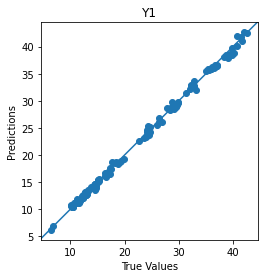

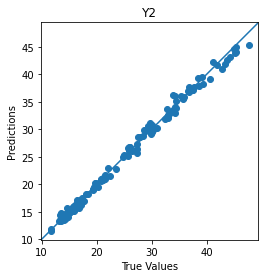

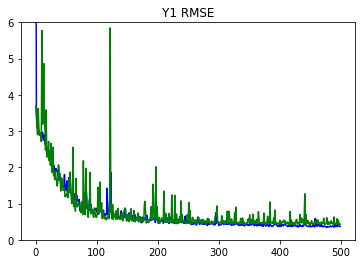

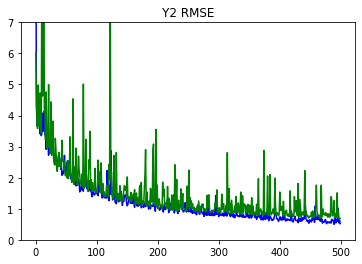

In [43]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)